<a href="https://colab.research.google.com/github/shivaraj245/Deeplearning/blob/main/Lab_5d_assignment_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_datasets

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
def map_image_with_noise (image , label):
    noise_factor=0.5
    image = tf.cast(image , dtype =tf.float32 )
    image = image /255.0
    factor = noise_factor * tf.random.normal(shape = image.shape)
    image_noisy = image + factor
    image_noisy = tf.clip_by_value(image_noisy , 0.0 , 1.0)
    return image_noisy , image


In [3]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.A0ALY0_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.A0ALY0_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
def denoising_encoder(inputs):
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)  # Downsample to (14, 14)

    conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)  # Downsample to (7, 7)

    return max_pool_2


def decoder(inputs):
    conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    up_sample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_1)  # Upsample to (14, 14)

    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(up_sample_1)
    up_sample_2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_2)  # Upsample to (28, 28)

    conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")(up_sample_2)
    return conv_3





In [5]:
def build_autoencoder():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    encoded = denoising_encoder(inputs)
    decoded = decoder(encoded)
    autoencoder = tf.keras.Model(inputs, decoded)
    return autoencoder

In [6]:
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
history = autoencoder.fit(train_dataset,
                          epochs=10,
                          steps_per_epoch=60000 // BATCH_SIZE,
                          validation_data=test_dataset,
                          validation_steps=10000 // BATCH_SIZE)

Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.3645 - val_loss: 0.3038
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.2998 - val_loss: 0.2992
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2954 - val_loss: 0.2951
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2929 - val_loss: 0.2933
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2904 - val_loss: 0.2921
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.2890 - val_loss: 0.2915
Epoch 7/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.2886 - val_loss: 0.2898
Epoch 8/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.2877 - val_loss: 0.2893
Epoch 9/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.2871 - val_loss: 0.2887
Epoch 10/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2865 - val_loss: 0.2883


In [8]:
def display_noisy_and_denoised_images(autoencoder, dataset):
    for noisy_images, original_images in dataset.take(1):
        denoised_images = autoencoder.predict(noisy_images)
        plt.figure(figsize=(20, 4))
        for i in range(10):
            # Display original noisy images
            ax = plt.subplot(2, 10, i + 1)
            plt.imshow(noisy_images[i].numpy().reshape(28, 28), cmap='gray')
            plt.title("Noisy")
            plt.axis("off")

            # Display denoised images
            ax = plt.subplot(2, 10, i + 11)
            plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
            plt.title("Denoised")
            plt.axis("off")
        plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  


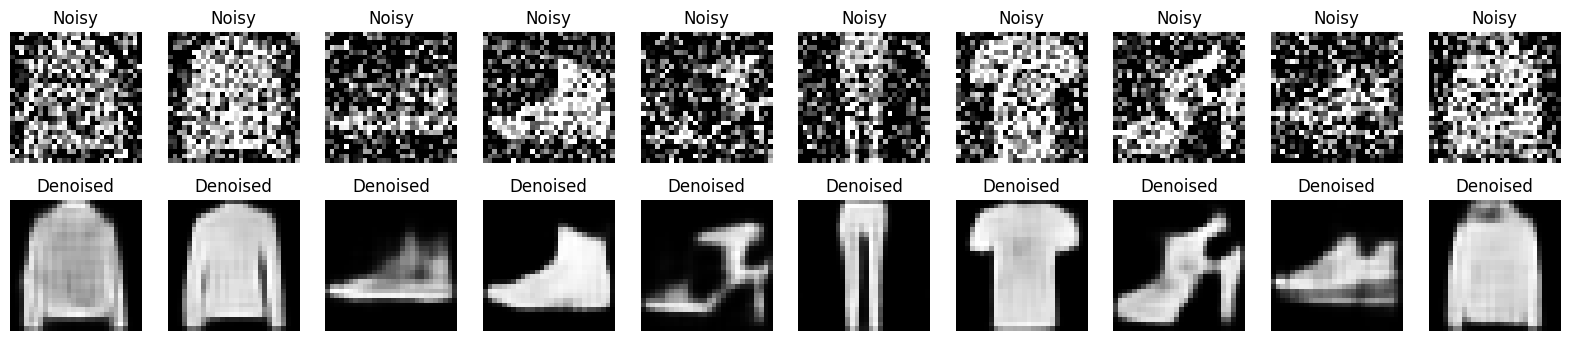

In [9]:
display_noisy_and_denoised_images(autoencoder, test_dataset)